In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, simps
from scipy.stats import rv_continuous
from scipy.special import gamma
from scipy.interpolate import interp1d
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import warnings
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid.inset_locator import inset_axes
warnings.filterwarnings('ignore')

# DMO

In [5]:
simname='Mochima2'

In [6]:
path = "/data/OWN/DMO/mochima2_Z5/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myDMO = wkbl.Galaxy_Hound(path)
print "centering"
zoom_reg = np.where(myDMO.dm.mass == myDMO.dm.mass.min())
nucenter = nbe.real_center(myDMO.dm.pos3d[zoom_reg], myDMO.dm.mass[zoom_reg])
myDMO.center_shift(nucenter)
myDMO.r_virial(600)
print "done r200 = {0}".format(myDMO.r200)
myDMO.redefine(2.5)
ok,myDMO.dm.rho,_= CF.getDensity(np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32), myDMO.dm.mass)


loading Dark matter..
centering
done r200 = 227.658094645


In [7]:
"""
K = np.sum(myDMO.dm.mass*(myDMO.dm.v)**2)
print K
myGkm = 6.673e-11*(1e-3**3)*myDMO.p.msuntokg#km^ 3 Msun^-1 s^-2
r_sorted = np.argsort(myDMO.dm.r)
M_i = np.cumsum(myDMO.dm.mass[r_sorted]) - myDMO.dm.mass[r_sorted]
m_i = myDMO.dm.mass[r_sorted]
r_i = myDMO.dm.r[r_sorted]*(1e-2*myDMO.p.pctocm)# in km
U =  np.sum(-myGkm*M_i*m_i/r_i)
print U
print K/U + 1
"""

'\nK = np.sum(myDMO.dm.mass*(myDMO.dm.v)**2)\nprint K\nmyGkm = 6.673e-11*(1e-3**3)*myDMO.p.msuntokg#km^ 3 Msun^-1 s^-2\nr_sorted = np.argsort(myDMO.dm.r)\nM_i = np.cumsum(myDMO.dm.mass[r_sorted]) - myDMO.dm.mass[r_sorted]\nm_i = myDMO.dm.mass[r_sorted]\nr_i = myDMO.dm.r[r_sorted]*(1e-2*myDMO.p.pctocm)# in km\nU =  np.sum(-myGkm*M_i*m_i/r_i)\nprint U\nprint K/U + 1\n'

In [8]:
ok,myDMO.dm.rho,_= CF.getDensity(np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32), myDMO.dm.mass)


In [9]:
def abg_logprofile(x,p_s,r_s,al,be,ga):
    x = 10**x
    power =  (be - ga) / (al)
    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
    return np.log10(10**p_s / denominator)

def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator

## Mass fit

In [10]:
Pcrit = myDMO.dm._p.rho_crit
Mdm = myDMO.dm.mass.min()
myradiuses = myDMO.dm.r[np.argsort(myDMO.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]


print R_P03
hsml= 0.2# R_P03
print hsml,R_P03
# R array logarithmic Bining
r_p = np.logspace(np.log10(0.2*hsml),np.log10(hsml),15)
# histogram of dm particles per logarithmic bin
n_dm,r = np.histogram(myDMO.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
r_size = r_p[1:]-r_p[:-1]
# density per shell
profileDMO_in = n_dm*myDMO.dm.mass.min()/vol
# center of bins
r_in = (r_p[:-1]+r_p[1:])/2.


# R array logarithmic Bining
r_p = np.logspace(np.log10(3*hsml),np.log10(2.5*myDMO.r200),150)
# histogram of dm particles per logarithmic bin
n_dm,r = np.histogram(myDMO.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
r_size = r_p[1:]-r_p[:-1]
# density per shell
profileDMO = n_dm*myDMO.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r


Delta_rho = (myDMO.dm.mass.min() /vol) + (4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)
Delta_rho2 = np.sqrt((myDMO.dm.mass.min()/np.sqrt(n_dm) /vol)**2 + (4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)**2)
Delta_rho3 =(4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)
Delta_rho4 =(myDMO.dm.mass.min() /vol)

# extra estatistics from Cfalcon density
mean = std = n = stdlog = np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myDMO.dm.r > r_p[i])&(myDMO.dm.r < r_p[i+1])&(myDMO.dm.r > hsml))
    n = np.append(n,len(shell[0]))
    mean = np.append(mean,np.mean(myDMO.dm.rho[shell]))
    std = np.append(std,np.std(myDMO.dm.rho[shell]))
    stdlog = np.append(stdlog,np.std(np.log10(myDMO.dm.rho[shell])))
    
n_dm_bin = n
m_obs = n_dm*myDMO.dm.mass.min()
n = np.array([len(myDMO.dm.mass[myDMO.dm.r<i]) for i in r]) 
r_dmo_profile =r

0.8373210354860829
0.2 0.8373210354860829


In [11]:
def abg_logprofile(x,p_s,r_s,al,be,ga):
    x = 10**x
    power =  (be - ga) / (al)
    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
    return np.log10(10**p_s / denominator)

def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator



def chi2_mass_bin_log(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using the full mass inside a shell
    between Ri and Rf
    """
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (np.log10(m_obs)- np.log10(expected))
    c = c**2
    return np.sum(c)



def chi2_rho_log(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using mean of rho per shell
    """
    rho_obs = profileDMO
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ stdlog
    c = c**2
    return np.sum(c)


In [12]:


m_rho = Minuit(chi2_rho_log, al=1., fix_al=True,
         po=7.0,    error_po=0.01,  limit_po =(5.,11.),
         r_s=7.3,  error_r_s=0.1,   limit_r_s=(20.,35),
         be=3.,     error_be=0.1,   limit_be =(2.5,3.5),
         ga=1.,     error_ga=0.1,   limit_ga =(.5,1.5))
m_rho.migrad();
chirhorho = chi2_rho_log(m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])
chibinrho= chi2_mass_bin_log(m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhorho,chibinrho)

FCN = 1.05796898536 
 TOTAL NCALL = 408 
 NCALLS = 408 
 
 
 EDM = 8.4867952193e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 6.48794 
 0.503306 
 0 
 0 
 5.0 
 11.0 
 
 
 
 
 2 
 r_s 
 30.0577 
 11.5246 
 0 
 0 
 20.0 
 35.0 
 
 
 
 
 3 
 al 
 1 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 4 
 be 
 3.26486 
 0.762864 
 0 
 0 
 2.5 
 3.5 
 
 
 
 
 5 
 ga 
 1.3584 
 0.10579 
 0 
 0 
 0.5 
 1.5 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 6.488e+00 & 5.033e-01 & & & 5.000e+00 & 1.100e+01 & \\
\hline
2 & $r_{s}$ & 3.006e+01 & 1.152e+01 & & & 2.000e+01 & 3.500e+01 & \\
\hline
3 & al & 1.000e+00 & 1.000e+00 & & & & & FIXED\\
\hline
4 & be & 3.265e+00 & 7.629e-01 & & & 2.500e+00 & 3.500e+00 & \\
\hline
5 & ga & 1.358e+00 & 1.058e-01 & & & 5.000e-01 & 1.500e+00 & \\
\hline
\end{tabular}

chi_rho = 1.06, chi_bin = 0.73


In [13]:
m_bin = Minuit(chi2_mass_bin_log, al=1., fix_al=True,
         po=7.0,    error_po=0.01,  limit_po =(5.,11.),
         r_s=7.3,  error_r_s=0.1,   limit_r_s=(20.,35),
         be=3.,     error_be=0.1,   limit_be =(2.5,3.5),
         ga=1.,     error_ga=0.1,   limit_ga =(.5,1.5))
m_bin.migrad();

chirhobin = chi2_rho_log(m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga'])
chibinbin= chi2_mass_bin_log(m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhobin,chibinbin)

FCN = 0.870303557795 
 TOTAL NCALL = 93 
 NCALLS = 93 
 
 
 EDM = 1.1236506824e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 6.90443 
 0.256416 
 0 
 0 
 5.0 
 11.0 
 
 
 
 
 2 
 r_s 
 20 
 12.8112 
 0 
 0 
 20.0 
 35.0 
 
 
 
 
 3 
 al 
 1 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 4 
 be 
 3.13949 
 0.265369 
 0 
 0 
 2.5 
 3.5 
 
 
 
 
 5 
 ga 
 1.21456 
 0.25238 
 0 
 0 
 0.5 
 1.5 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 6.904e+00 & 2.564e-01 & & & 5.000e+00 & 1.100e+01 & \\
\hline
2 & $r_{s}$ & 2.000e+01 & 1.281e+01 & & & 2.000e+01 & 3.500e+01 & \\
\hline
3 & al & 1.000e+00 & 1.000e+00 & & & & & FIXED\\
\hline
4 & be & 3.139e+00 & 2.654e-01 & & & 2.500e+00 & 3.500e+00 & \\
\hline
5 & ga & 1.215e+00 & 2.524e-01 & & & 5.000e-01 & 1.500e+00 & \\
\hline
\end{tabular}

chi_rho = 3.03, chi_bin = 0.87


In [14]:
#polfit
chirhopol = chi2_rho_log(7.663,5.552,1,2.636,0.819)
chibinpol= chi2_mass_bin_log(7.663,5.552,1,2.636,0.819)
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhopol,chibinpol)

chi_rho = 260.90, chi_bin = 11.44


<IPython.core.display.Javascript object>


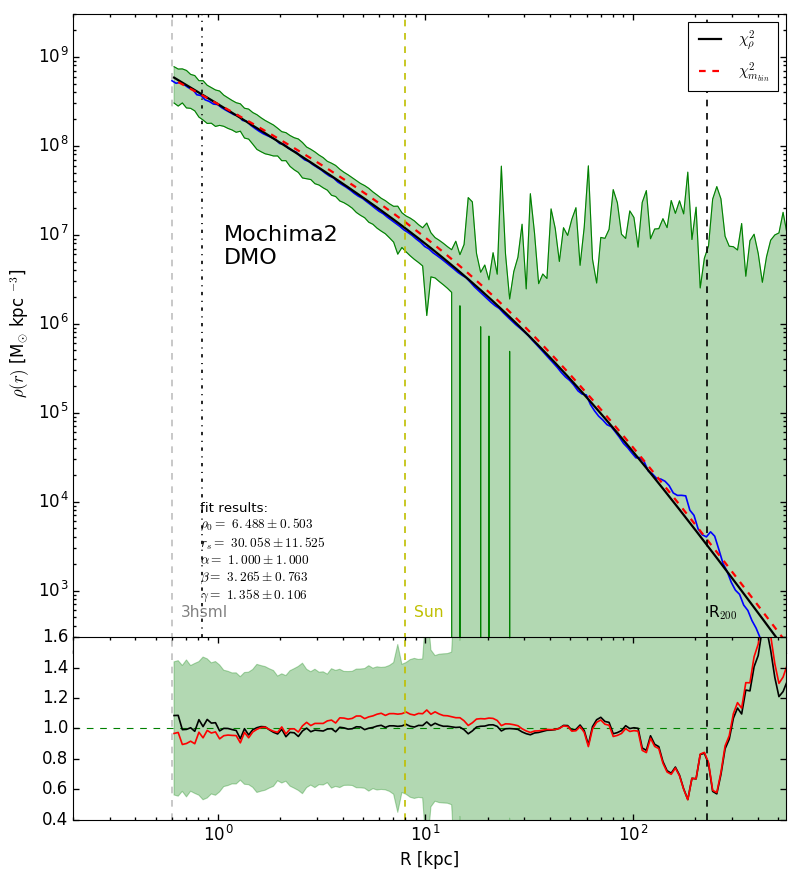

fit results: 
$\rho_0 =$ $6.488 \pm 0.503$
$r_s =$ $30.058 \pm 11.525$
$\alpha =$ $1.000 \pm 1.000$
$\beta =$ $3.265 \pm 0.763$
$\gamma =$ $1.358 \pm 0.106$



In [15]:
fig, [ax,ax1] = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3.5, 1]},figsize=[10,11],sharex=True)
ax.set_xlim([hsml,2.4*myDMO.r200])
ax1.set_xlim([hsml,2.4*myDMO.r200])
ax1.set_ylim([.4,1.6])
ax.set_ylim([2e2,3e9])
ax.set_xscale('log')
ax1.set_xscale('log')
ax.set_yscale('log')
ax1.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)


#define sigma pluss and sigma minus lines
mean_plus = profileDMO+std
mean_minu = profileDMO-std

#  plot things
#ax.scatter(myDMO.dm.r,myDMO.dm.rho,s=0.02,lw=0,alpha=0.6,c='#FF9100')
mean_minu[np.isnan(np.log10(mean_minu))] = 0
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')

ax.fill_between(r,mean_plus,mean_minu,color="g",alpha=0.3)
#ax.errorbar(r,profileDMO,xerr=bin_size,yerr=std,alpha=0.5)

#ax.scatter(myDMO.dm.r,myDMO.dm.rho,s=0.2,lw=0,alpha=0.2,c='gray')

#plot means
#ax.plot(r_p[:-1],mean,lw=1.5)
ax.plot(r_p[:-1],profileDMO,lw=1.5)
## rho fit
ax.plot(r,(abg_profile(r,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k",lw=2,label=r"$\chi^2_{\rho}$")
## spehere mass
#ax.plot(r,(abg_profile(r,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],m_SC.values['be'],m_SC.values['ga'])),
#        "r-",lw=2)
## shell mass
ax.plot(r[1:],(abg_profile(r[:-1],m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga'])),
        "r--",lw=2,label=r"$\chi^2_{m_{bin}}$ ")

texto = "fit results: \n"
texto += r"$\rho_0 =$ ${0:.3f} \pm {1:.3f}$".format(m_rho.values["po"],m_rho.errors["po"])+"\n"
texto += r"$r_s =$ ${0:.3f} \pm {1:.3f}$".format(m_rho.values["r_s"],m_rho.errors["r_s"])+"\n"
texto += r"$\alpha =$ ${0:.3f} \pm {1:.3f}$".format(m_rho.values["al"],m_rho.errors["al"])+"\n"
texto += r"$\beta =$ ${0:.3f} \pm {1:.3f}$".format(m_rho.values["be"],m_rho.errors["be"])+"\n"
texto += r"$\gamma =$ ${0:.3f} \pm {1:.3f}$".format(m_rho.values["ga"],m_rho.errors["ga"])+"\n"
fig.text(0.28,0.7,simname+"\nDMO",fontsize=20)
fig.text(0.25,0.3,texto,fontsize=12)
ax.text(3*hsml*1.1,5e2,"3hsml",color='gray',fontsize=14)
ax.text(8*1.1,5e2,"Sun",color='y',fontsize=14)
ax.text(myDMO.r200*1.01,5e2,r"R$_{200}$",color='k',fontsize=14)
r_dm = r


#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myDMO.r200,c='k',linestyle='--',lw=1.5) #r200
ax.axvline(x=R_P03,c='k',linestyle='-.',lw=1.5) #power radius
#########33

##
ax1.axhline(y=1.,color="g",linestyle="--")
## rho fit
r_local = np.logspace(np.log10(hsml),np.log10(2.5*myDMO.r200),100)
ax1.plot(r,(abg_profile(r,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga']))/profileDMO,
        "k",lw=1.5,label=r"$\chi^2(\rho) ")

ax1.plot(r_in,(abg_profile(r_in,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga']))/profileDMO_in,
        "k--",lw=1.5,label=r"$\chi^2(\rho) ")
## spehere mass
#ax.plot(r,(abg_profile(r,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],m_SC.values['be'],m_SC.values['ga'])),
#        "r-",lw=2)
## shell mass
ax1.fill_between(r,mean_plus/profileDMO,mean_minu/profileDMO,color="g",alpha=0.3)
ax1.plot(r,(abg_profile(r,m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga']))/profileDMO,
        "r-",lw=1.5)
ax1.plot(r_in,(abg_profile(r_in,m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga']))/profileDMO_in,
        "r--",lw=1.5)

#horizontal lines
ax1.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax1.axvline(x=myDMO.r200,c='k',linestyle='--',lw=1.5) #r200


legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
# layout
fig.tight_layout(h_pad=-1.65)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/HaloBdmoprofile.png",dpi=300)
print texto

In [18]:
#### TAKES TIME ####

myGkpc = 6.673e-11*((1e-3/myDMO.p.kpctokm)**3)*myDMO.p.msuntokg#kpc^ 3 Msun^-1 s^-2
pos = np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32)#*myDMO.p.kpctokm
#ok, acc, Phy = CF.getGravity(pos,myDMO.dm.mass,0.190,G=myGkpc)

In [19]:
"""
bin_num = 512

pot_sph, bins_pot = np.histogram(r2,bins=bin_num,
                                 weights=Phy)
n, _ = np.histogram(r2,bins=bin_num)

bin_num = 512
bins_pot = np.linspace(0.,myDMO.dm.r.max(),512)
pot_sph_vesc, bins_pot_vesc = np.histogram(r2[(r2<myDMO.r200**2)], bins=bin_num, weights=Phy[(r2<myDMO.r200**2)])
rmax = np.sqrt(bins_pot[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()])[0]
pot_max = (pot_sph/n)[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()][0]
"""

'\nbin_num = 512\n\npot_sph, bins_pot = np.histogram(r2,bins=bin_num,\n                                 weights=Phy)\nn, _ = np.histogram(r2,bins=bin_num)\n\nbin_num = 512\nbins_pot = np.linspace(0.,myDMO.dm.r.max(),512)\npot_sph_vesc, bins_pot_vesc = np.histogram(r2[(r2<myDMO.r200**2)], bins=bin_num, weights=Phy[(r2<myDMO.r200**2)])\nrmax = np.sqrt(bins_pot[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()])[0]\npot_max = (pot_sph/n)[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()][0]\n'

In [20]:
fig, ax = plt.subplots(2,2,figsize=[12,12])
for i in range(2):
    for j in range(2):
        ax[i,j].set_ylim([0,0.006])
        ax[i,j].set_xlim([0,700])

path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_3.0kpc_velocity_no_divergence.txt'
fdv_plot_chi2_max_edd(ax[0,0],myDMO,path, 2.,4.,width=0.8,save=False,
                      outname='/home/arturo/Pictures/coco.png')
path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_2.0kpc_velocity_no_divergence.txt'
v, fv = eddingtong_from_file(path)
fl = interp1d(v,fv)
path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_4.0kpc_velocity_no_divergence.txt'
v, fv = eddingtong_from_file(path)
fh = interp1d(v,fv)
ax[0,0].fill_between(v,fl(v),fh(v),facecolor="gray",alpha=0.2,interpolate=False)

path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_8.0kpc_velocity_no_divergence.txt'
fdv_plot_chi2_max_edd(ax[0,1],myDMO,path, 7.,9.,width=0.8,save=False,
                      outname='/home/arturo/Pictures/coco.png')
path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_7.0kpc_velocity_no_divergence.txt'
v, fv = eddingtong_from_file(path)
fl = interp1d(v,fv)
path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_9.0kpc_velocity_no_divergence.txt'
v, fv = eddingtong_from_file(path)
fh = interp1d(v,fv)
ax[0,1].fill_between(v,fl(v),fh(v),facecolor="gray",alpha=0.2,interpolate=False)

path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_20.0kpc_velocity_no_divergence.txt'
fdv_plot_chi2_max_edd(ax[1,0],myDMO,path, 19.,21.,width=0.8,save=False,
                      outname='/home/arturo/Pictures/coco.png')
path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_19.0kpc_velocity_no_divergence.txt'
v, fv = eddingtong_from_file(path)
fl = interp1d(v,fv)
path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_21.0kpc_velocity_no_divergence.txt'
v, fv = eddingtong_from_file(path)
fh = interp1d(v,fv)
ax[1,0].fill_between(v,fl(v),fh(v),facecolor="gray",alpha=0.2,interpolate=False)

path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_50.0kpc_velocity_no_divergence.txt'
fdv_plot_chi2_max_edd(ax[1,1],myDMO,path, 49.,51.,width=0.8,save=False,
                      outname='/home/arturo/Pictures/coco.png')
path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_49.0kpc_velocity_no_divergence.txt'
v, fv = eddingtong_from_file(path)
fl = interp1d(v,fv)
path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Thoma/f_Eddington_Mochima2_DMO_DM_only_Rmax=500.0kpc_51.0kpc_velocity_no_divergence.txt'
v, fv = eddingtong_from_file(path)
fh = interp1d(v,fv)
ax[1,1].fill_between(v,fl(v),fh(v),facecolor="gray",alpha=0.2,interpolate=False)

ax[0,1].set_ylabel("")
ax[1,1].set_ylabel("")
fig.tight_layout(w_pad=-4.15)
for i in range(2):
    ax[i,0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
    ax[i,1].tick_params(axis='both', which='major', labelsize=15,labelleft=False, size=5,width=1.2)
    ax[i,0].tick_params(axis='both', which='minor', labelsize=15, size=5,width=1.2)
    ax[i,1].tick_params(axis='both', which='minor', labelsize=15,labelleft=False, size=3,width=1.2)

<IPython.core.display.Javascript object>

NameError: name 'fdv_plot_chi2_max_edd' is not defined

<IPython.core.display.Javascript object>


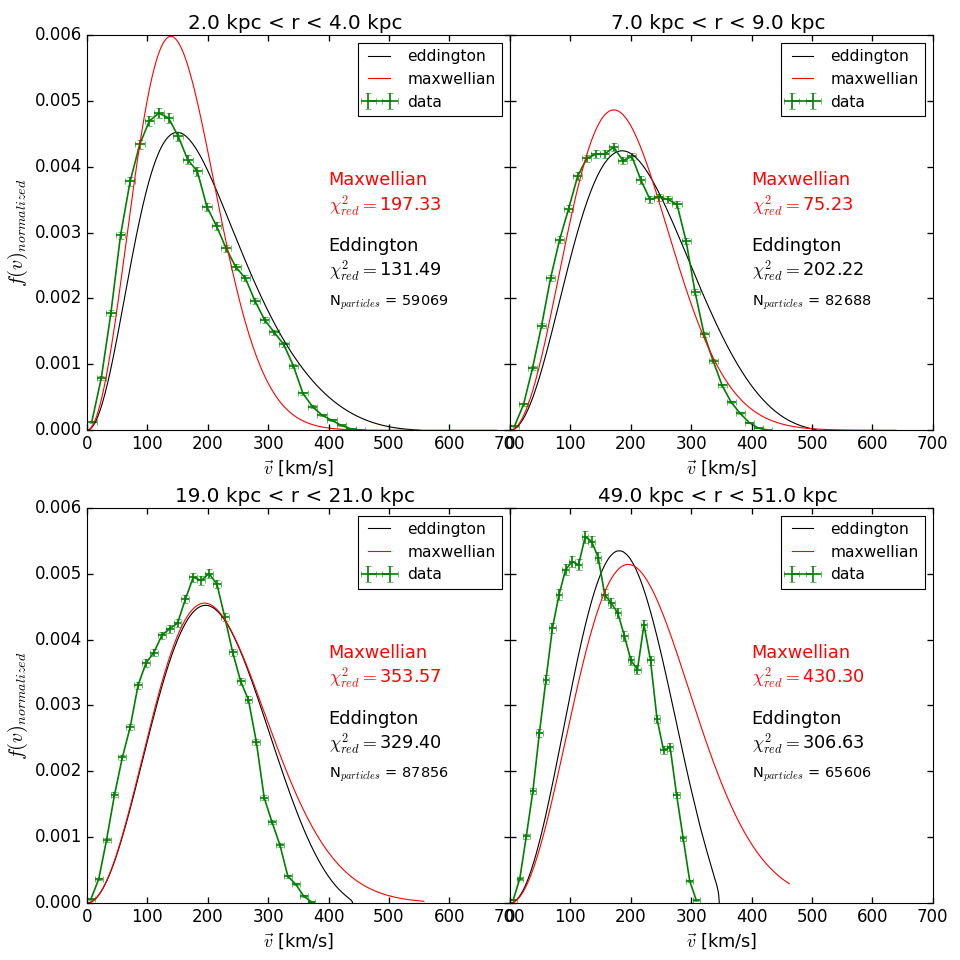

138.93846405534453
932211.6162343025
171.89042245004077
1229624.0232310295
194.7025135355093
1140957.435851097
195.66116075432961
705934.6916999817


In [69]:
fig, ax = plt.subplots(2,2,figsize=[12,12])
for i in range(2):
    for j in range(2):
        ax[i,j].set_ylim([0,0.006])
        ax[i,j].set_xlim([0,700])

path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Martin/fv_df0_anis0_mod6_bar-1_r3_rmax500_div0.dat'
fdv_plot_chi2_max_edd(ax[0,0],myDMO,path, 2.,4.,width=0.8,save=False,source="MS",
                      outname='/home/arturo/Pictures/coco.png')

path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Martin/fv_df0_anis0_mod6_bar-1_r8_rmax500_div0.dat'
fdv_plot_chi2_max_edd(ax[0,1],myDMO,path, 7.,9.,width=0.8,save=False,source="MS",
                      outname='/home/arturo/Pictures/coco.png')

path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Martin/fv_df0_anis0_mod6_bar-1_r20_rmax500_div0.dat'
fdv_plot_chi2_max_edd(ax[1,0],myDMO,path, 19.,21.,width=0.8,save=False,source="MS",
                      outname='/home/arturo/Pictures/coco.png')

path = '/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/MochimaDMO/Martin/fv_df0_anis0_mod6_bar-1_r50_rmax500_div0.dat'
fdv_plot_chi2_max_edd(ax[1,1],myDMO,path, 49.,51.,width=0.8,save=False,source="MS",
                      outname='/home/arturo/Pictures/coco.png')

ax[0,1].set_ylabel("")
ax[1,1].set_ylabel("")
fig.tight_layout(w_pad=-4.15)
for i in range(2):
    ax[i,0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
    ax[i,1].tick_params(axis='both', which='major', labelsize=15,labelleft=False, size=5,width=1.2)
    ax[i,0].tick_params(axis='both', which='minor', labelsize=15, size=5,width=1.2)
    ax[i,1].tick_params(axis='both', which='minor', labelsize=15,labelleft=False, size=3,width=1.2)

# Hydro

In [21]:
pathsim = "/data/OWN/SF1test/SF0/mstar1_T3600/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhydro = wkbl.Galaxy_Hound(pathsim,"halo,stars,gas")
ok,rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32), myhydro.st.mass)
centro_rho = myhydro.st.pos3d[np.where(rho == rho.max())][0]
print "density",centro_rho
myhydro.center_shift(centro_rho)
myhydro.r_virial(600,n=2.5)
myhydro.redefine(2.5)

loading Dark matter..
loading Stars..
loading Gas..
density [-0.05224577  0.02378982  0.09318393]
| r_200 = 229.024 kpc
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.060e+12 M_sun
| p_dm_200      =  9.263e+05 particles
| stellar mass  =  1.203e+11 M_sun
| p_st_200      =  5.250e+05 psrticles
| gas mass      =  1.499e+11 M_sun
| p_gs_200      =  2.275e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |17, 0, 0|
| D =| 0,13, 0|
|    | 0, 0, 2|


In [22]:
ok,myhydro.dm.rho,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32), myhydro.dm.mass)

## virial parameter q

In [23]:
"""
pos_bar = np.concatenate((myhydro.st.pos3d, myhydro.gs.pos3d))
mass_bar = np.concatenate((myhydro.st.mass,myhydro.gs.mass))
nbe.real_center(pos_bar,mass_bar)
pos = np.concatenate((myhydro.dm.pos3d, myhydro.st.pos3d, myhydro.gs.pos3d))*1e-2*myhydro.p.pctocm # km
mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
r_par = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))
r_sorted = np.argsort(r_par)
M_i = np.cumsum(mass[r_sorted])
m_i = mass[r_sorted]
r_i = r_par[r_sorted]
U_hydro = np.sum(-myG*M_i*m_i/r_i)
k_B = 1.3806503e-23 *1e-6/ myhydro.p.msuntokg
m_H = myhydro.p.mH*1e-3/ myhydro.p.msuntokg
E_k_dm = 0.5*(myhydro.dm.v**2)*myhydro.dm.mass
E_k_st = 0.5*(myhydro.st.v**2)*myhydro.st.mass
E_k_gs = 1.5* myhydro.gs.mass * myhydro.gs.temp2 * (k_B / m_H)#0.5*(myhydro.gs.v**2)*myhydro.gs.mass
K_hydro = np.sum(2*E_k_dm)+np.sum(2*E_k_st)+np.sum(2*E_k_gs)
K_hydro / U_hydro +1
print "E_DM = {0:1.4e}, E_st = {1:1.4e}, E_gs = {2:1.4e}".format(np.sum(2*E_k_dm),np.sum(2*E_k_st),np.sum(2*E_k_gs))
"""

'\npos_bar = np.concatenate((myhydro.st.pos3d, myhydro.gs.pos3d))\nmass_bar = np.concatenate((myhydro.st.mass,myhydro.gs.mass))\nnbe.real_center(pos_bar,mass_bar)\npos = np.concatenate((myhydro.dm.pos3d, myhydro.st.pos3d, myhydro.gs.pos3d))*1e-2*myhydro.p.pctocm # km\nmass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))\nr_par = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))\nr_sorted = np.argsort(r_par)\nM_i = np.cumsum(mass[r_sorted])\nm_i = mass[r_sorted]\nr_i = r_par[r_sorted]\nU_hydro = np.sum(-myG*M_i*m_i/r_i)\nk_B = 1.3806503e-23 *1e-6/ myhydro.p.msuntokg\nm_H = myhydro.p.mH*1e-3/ myhydro.p.msuntokg\nE_k_dm = 0.5*(myhydro.dm.v**2)*myhydro.dm.mass\nE_k_st = 0.5*(myhydro.st.v**2)*myhydro.st.mass\nE_k_gs = 1.5* myhydro.gs.mass * myhydro.gs.temp2 * (k_B / m_H)#0.5*(myhydro.gs.v**2)*myhydro.gs.mass\nK_hydro = np.sum(2*E_k_dm)+np.sum(2*E_k_st)+np.sum(2*E_k_gs)\nK_hydro / U_hydro +1\nprint "E_DM = {0:1.4e}, E_st = {1:1.4e}, E_gs = {2:1.4e}".format(np.sum(2*E_k_d

## mass fit

In [24]:
Pcrit = myhydro.dm._p.rho_crit
Mdm = myhydro.dm.mass.min()
myradiuses = myhydro.dm.r[np.argsort(myhydro.dm.r)]

tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print R_P03
hsml=  myhydro.gs.hsml.min()

# R array logarithmic Bining
r_p = np.logspace(np.log10(0.2*hsml),np.log10(hsml),15)
# histogram of dm particles per logarithmic bin
n_hydro,r = np.histogram(myhydro.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro_in = n_hydro*myhydro.dm.mass.min()/vol
# center of bins
r_in = (r_p[:-1]+r_p[1:])/2.



# R array logarithmic Bining
r_p = np.logspace(np.log10(2.*hsml),np.log10(2.5*myhydro.r200),100)
# histogram of dm particles per logarithmic bin
n_hydro,r = np.histogram(myhydro.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro = n_hydro*myhydro.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r
# extra estatistics from Cfalcon density
mean_hydro = std_hydro = stdlog_hydro = n_hydro=np.array([])
for i in range(len(r_p)-1):
    shell_hydro = np.where((myhydro.dm.r > r_p[i])&(myhydro.dm.r < r_p[i+1])&(myhydro.dm.r > hsml))
    n_hydro = np.append(n_hydro,len(shell_hydro[0]))
    mean_hydro = np.append(mean_hydro,np.mean(myhydro.dm.rho[shell_hydro]))
    std_hydro = np.append(std_hydro,np.std(myhydro.dm.rho[shell_hydro]))
    stdlog_hydro = np.append(stdlog_hydro,np.std(np.log10(myhydro.dm.rho[shell_hydro])))

m_obs_hydro = n_hydro*myhydro.dm.mass.min()
n_hydro = np.array([len(myhydro.dm.mass[myhydro.dm.r<i]) for i in r]) 


1.9499395410017228


In [25]:


def chi2_mass_bin_hydro(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using the full mass inside a shell
    between Ri and Rf
    """
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (np.log10(m_obs_hydro)- np.log10(expected))
    c = c**2
    return np.sum(c)


def chi2_rho_hydro(po,r_s,al,be,ga):
    rho_obs = profilehydro
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ stdlog_hydro
    c = c**2
    return np.sum(c)

In [26]:
m_rho_hydro = Minuit(chi2_rho_hydro,
         po=7.0,    error_po=0.01,  limit_po =(6.,13.),
         r_s=4.3,  error_r_s=0.1,   limit_r_s=(1.,10),
         al=2.8,     error_al=0.1,   limit_al=(0.5,5),
         be=2.5,     error_be=0.1,   limit_be =(2.,3.5),
         ga=0.5,     error_ga=0.1,   limit_ga =(0.0,1.5))
m_rho_hydro.migrad();
chirhorho = chi2_rho_hydro(m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])
chibinrho= chi2_mass_bin_hydro(m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhorho,chibinrho)

FCN = 12.1216113678 
 TOTAL NCALL = 325 
 NCALLS = 325 
 
 
 EDM = 7.2536741985e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 7.97101 
 0.24672 
 0 
 0 
 6.0 
 13.0 
 
 
 
 
 2 
 r_s 
 5.24038 
 0.872041 
 0 
 0 
 1.0 
 10.0 
 
 
 
 
 3 
 al 
 1.52192 
 0.499226 
 0 
 0 
 0.5 
 5.0 
 
 
 
 
 4 
 be 
 2.74093 
 0.190801 
 0 
 0 
 2.0 
 3.5 
 
 
 
 
 5 
 ga 
 0.417877 
 0.212794 
 0 
 0 
 0.0 
 1.5 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 7.971e+00 & 2.467e-01 & & & 6.000e+00 & 1.300e+01 & \\
\hline
2 & $r_{s}$ & 5.240e+00 & 8.720e-01 & & & 1.000e+00 & 1.000e+01 & \\
\hline
3 & al & 1.522e+00 & 4.992e-01 & & & 5.000e-01 & 5.000e+00 & \\
\hline
4 & be & 2.741e+00 & 1.908e-01 & & & 2.000e+00 & 3.500e+00 & \\
\hline
5 & ga & 4.179e-01 & 2.128e-01 & & & 0.000e+00 & 1.500e+00 & \\
\hline
\end{tabular}

chi_rho = 12.12, chi_bin = 0.80


In [27]:
m_binH = Minuit(chi2_mass_bin_hydro,
         po=7.0,    error_po=0.01,  limit_po =(6.,13.),
         r_s=4.3,  error_r_s=0.1,   limit_r_s=(1.,20),
         al=2.8,     error_al=0.1,   limit_al=(0.5,4),
         be=2.5,     error_be=0.1,   limit_be =(2.,3.5),
         ga=0.5,     error_ga=0.1,   limit_ga =(0.0,1.5))
m_binH.migrad();
chirhobin = chi2_rho_hydro(m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])
chibinbin= chi2_mass_bin_hydro(m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhobin,chibinbin)


FCN = 0.564718771453 
 TOTAL NCALL = 632 
 NCALLS = 632 
 
 
 EDM = 0.000149905311591 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 8.65076 
 1.06594 
 0 
 0 
 6.0 
 13.0 
 
 
 
 
 2 
 r_s 
 5.45105 
 6.25781 
 0 
 0 
 1.0 
 20.0 
 
 
 
 
 3 
 al 
 0.790887 
 0.750892 
 0 
 0 
 0.5 
 4.0 
 
 
 
 
 4 
 be 
 3.16873 
 1.32777 
 0 
 0 
 2.0 
 3.5 
 
 
 
 
 5 
 ga 
 0.00581251 
 1.18614 
 0 
 0 
 0.0 
 1.5 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 8.651e+00 & 1.066e+00 & & & 6.000e+00 & 1.300e+01 & \\
\hline
2 & $r_{s}$ & 5.451e+00 & 6.258e+00 & & & 1.000e+00 & 2.000e+01 & \\
\hline
3 & al & 7.909e-01 & 7.509e-01 & & & 5.000e-01 & 4.000e+00 & \\
\hline
4 & be & 3.169e+00 & 1.328e+00 & & & 2.000e+00 & 3.500e+00 & \\
\hline
5 & ga & 5.813e-03 & 1.186e+00 & & & 0.000e+00 & 1.500e+00 & \\
\hline
\end{tabular}

chi_rho = 19.10, chi_bin = 0.56


In [28]:
#polfit
chirhopol = chi2_rho_hydro(7.663,4.425,2.895,2.541,8e-9)
chibinpol= chi2_mass_bin_hydro(7.663,4.425,2.895,2.541,8e-9)
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhopol,chibinpol)

chi_rho = 1240.93, chi_bin = 13.95


<IPython.core.display.Javascript object>


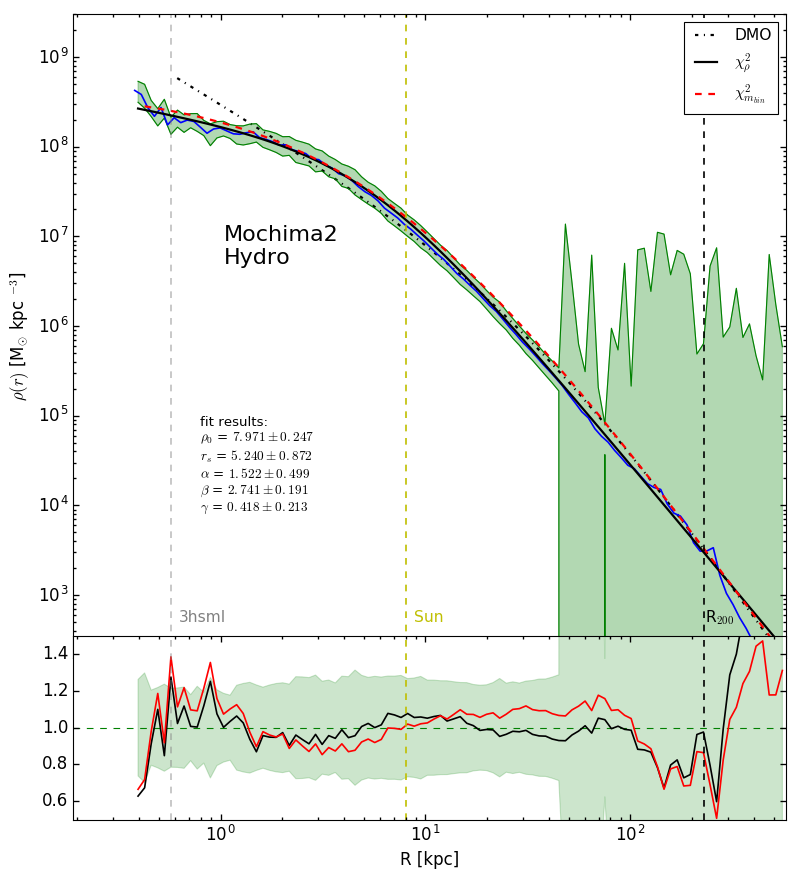

In [33]:
fig, [ax,ax1] = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3.5, 1]},sharex=True,figsize=[10,11])
ax.set_xlim([hsml,2.5*myhydro.r200])
ax1.set_xlim([hsml,2.5*myhydro.r200])
ax1.set_ylim([.5,1.5])
ax.set_ylim([2e2,3e9])
ax.set_xscale('log')
ax1.set_xscale('log')
ax.set_yscale('log')
ax1.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)


#define sigma pluss and sigma minus lines
mean_plus = profilehydro+std_hydro
mean_minu = profilehydro-std_hydro
ax.plot(r_dmo_profile,(abg_profile(r_dmo_profile,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k-.",lw=2,alpha=1,label='DMO')
#  plot things
#ax.scatter(myhydro.dm.r,myhydro.dm.rho,s=0.02,lw=0,alpha=0.6,c='#FF9100')
mean_minu[np.isnan(np.log10(mean_minu))] = 0
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')

ax.fill_between(r,mean_plus,mean_minu,color="g",alpha=0.3)
#ax.errorbar(r,profileDMO,xerr=bin_size,yerr=std,alpha=0.5)

#ax.scatter(myhydro.dm.r,myhydro.dm.rho,s=0.2,lw=0,alpha=0.2,c='gray')

#plot means
#ax.plot(r_p[:-1],mean,lw=1.5)
ax.plot(r_p[:-1],profilehydro,lw=1.5)
## rho fit
ax.plot(r,(abg_profile(r,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])),
        "k",lw=2,label=r"$\chi^2_{\rho}$")

## shell mass
ax.plot(r[1:],(abg_profile(r[:-1],m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])),
        "r--",lw=2,label=r"$\chi^2_{m_{bin}}$ ")

texto = "fit results: \n"
texto += r"$\rho_0$ = $ {0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["po"],m_rho_hydro.errors["po"])+"\n"
texto += r"$r_s$ = ${0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["r_s"],m_rho_hydro.errors["r_s"])+"\n"
texto += r"$\alpha$ = ${0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["al"],m_rho_hydro.errors["al"])+"\n"
texto += r"$\beta$ = ${0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["be"],m_rho_hydro.errors["be"])+"\n"
texto += r"$\gamma$ = ${0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["ga"],m_rho_hydro.errors["ga"])+"\n"
fig.text(0.28,0.7,simname+"\nHydro",fontsize=20)
fig.text(0.25,0.4,texto,fontsize=12)
ax.text(3*hsml*1.1,5e2,"3hsml",color='gray',fontsize=14)
ax.text(8*1.1,5e2,"Sun",color='y',fontsize=14)
ax.text(myhydro.r200*1.01,5e2,r"R$_{200}$",color='k',fontsize=14)
r_dm = r

#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhydro.r200,c='k',linestyle='--',lw=1.5) #r200

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
#########33

##
ax1.axhline(y=1.,color="g",linestyle="--")
## rho fit
r_local = np.logspace(np.log10(hsml),np.log10(2.5*myhydro.r200),100)
ax1.plot(r,(abg_profile(r,m_rho_hydro.values['po'],m_rho_hydro.values['r_s'],
                          m_rho_hydro.values['al'],m_rho_hydro.values['be'],
                          m_rho_hydro.values['ga']))/profilehydro,
        "k",lw=1.5,label=r"$\chi^2(\rho) ")


## spehere mass
#ax.plot(r,(abg_profile(r,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],m_SC.values['be'],m_SC.values['ga'])),
#        "r-",lw=2)
## shell mass
ax1.fill_between(r,mean_plus/profilehydro,mean_minu/profilehydro,color="g",alpha=0.2)

ax1.plot(r,(abg_profile(r,m_binH.values['po'],m_binH.values['r_s'],
                          m_binH.values['al'],m_binH.values['be'],
                          m_binH.values['ga']))/profilehydro,
        "r-",lw=1.5)
ax1.plot(r_in,(abg_profile(r_in,m_binH.values['po'],m_binH.values['r_s'],
                                m_binH.values['al'],m_binH.values['be'],
                                m_binH.values['ga']))/profilehydro_in,
        "r--",lw=1.5)

#horizontal lines
ax1.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax1.axvline(x=myhydro.r200,c='k',linestyle='--',lw=1.5) #r200

############
"""
inax = fig.add_axes([0.26,0.4,0.25,0.25],axisbg='w')
inax.set_xlabel('r [kpc]', fontsize=14)
inax.set_ylabel(r'$ln(\rho)/ln(r)$', fontsize=25)
inax.set_xscale('log')
inax.set_ylim([-3,1])
inax.set_xlim([0.2,30])
x = np.log(r_p[valid])
y = np.log(profilehydro[valid])#/np.log(r_p[valid])
dy = np.gradient(y)
dx = np.gradient(x)
dlnp = np.gradient(np.log(abg_profile(r_p[valid],m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])))
dlnr = np.gradient(np.log(r_p[valid]))
inax.plot(r_p[valid],dy/dx,'g',lw=1.5)
inax.plot(r_p[valid],dlnp/dlnr,'r',lw=2)
inax.axhline(y=-m_binH.values['ga'],color='gray',linestyle='--',linewidth=2)
inax.text(3,0,"$\gamma$ = "+"{0:.3f}".format(-m_binH.values['ga']))
"""
# layout
fig.tight_layout(h_pad=-1.65)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/HaloBhydroprofile.png",dpi=300)
##########################################################################################
##########################################################################################


In [25]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "##################  DM profile ####################"

print texto

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
##################  DM profile ####################
fit results: 
$\rho_0$ = $ 7.971 \pm 0.247$
$r_s$ = $5.240 \pm 0.872$
$\alpha$ = $1.522 \pm 0.499$
$\beta$ = $2.741 \pm 0.191$
$\gamma$ = $0.418 \pm 0.213$



In [26]:
def my_int(Ri,Rf,po,r_s,al,be,ga):
    r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
    rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
    return 4* np.pi * simps(rho_test,r_test)

print "integrated mass fit = {0:1.3e}".format(my_int(hsml,myhydro.r200,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga']))
print "integrates rho fit = {0:1.3e}".format(my_int(hsml,myhydro.r200,m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga']))
print "mass inside r200 = {0:1.3e}".format(myhydro.dm.mass[(myhydro.dm.r>hsml)&(myhydro.dm.r<myhydro.r200)].sum())


integrated mass fit = 9.825e+11
integrates rho fit = 1.027e+12
mass inside r200 = 1.060e+12


# Stars 

In [27]:
ok,myhydro.st.rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32), myhydro.st.mass)

In [28]:
stars_bins=70

print 10**1.3
xedges = np.logspace(-1,np.log10(12),stars_bins)
yedges = np.linspace(-1.,1.,stars_bins/2)
dens_hist = np.zeros([len(yedges)-1,len(xedges)-1])
sigma_st = sigma_log_st = np.zeros([len(yedges)-1,len(xedges)-1])

print dens_hist.shape
for i in range(len(xedges[:-1])):
    for j in range(len(yedges[:-1])):
        Rcon = (myhydro.st.R >= xedges[i] )&(myhydro.st.R < xedges[i+1] )
        Zcon = (myhydro.st.pos3d[:,2] >= yedges[j])&(myhydro.st.pos3d[:,2] < yedges[j+1])
        mass = np.sum(myhydro.st.mass[np.where(Rcon&Zcon)])
        sigma_st[j][i] = np.std(myhydro.st.rho[np.where(Rcon&Zcon)])
        sigma_log_st[j][i] = np.std(np.log10(myhydro.st.rho[np.where(Rcon&Zcon)]))
        volume = np.pi * (yedges[j+1]-yedges[j]) * (xedges[i+1]**2 - xedges[i]**2)
        dens_hist [j][i] = mass / volume 
    


19.9526231497
(34, 69)


In [29]:
def McMBulge(R,z,B_0,r0,al,r_cut,q):
        x = np.sqrt(R**2 + (z/q)**2)
        bulge = (10**B_0) * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge
    
def McMDisc(x,z,z_d,D_0,Rd):
        disc = (10**D_0) * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc

def stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    U = [R,z]
    return (McMBulge(U[0],U[1],B_0,r0,al,r_cut,q)+McMDisc(U[0],U[1],z_d,d_0,Rd)+McMDisc(U[0],U[1],z_D,D_0,RD))



R_array = (xedges[1:] + xedges[:-1])/2
Z_array = (yedges[1:] + yedges[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)

def chi2_st(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    chi2_array =np.array([])
    expected = stars(R,Z,B_0,r0,al,r_cut,q,D_0,z_d,Rd,D_0,z_D,RD)
    observed = dens_hist
    c = (np.log10(observed) - np.log10(expected)) #/ sigma_log_st
    c = c**2
    return np.nansum(c)


def mass_check(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    bins = 101
    edge = 20
    zedge = edge/10.
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-zedge,zedge,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * stars(U[0],U[1],B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhydro.st.mass[np.where((myhydro.st.R<50.)&(np.abs(myhydro.st.pos3d[:,2])<zedge))])
    diff = (data_in - F)**2
    return  diff

<IPython.core.display.Javascript object>


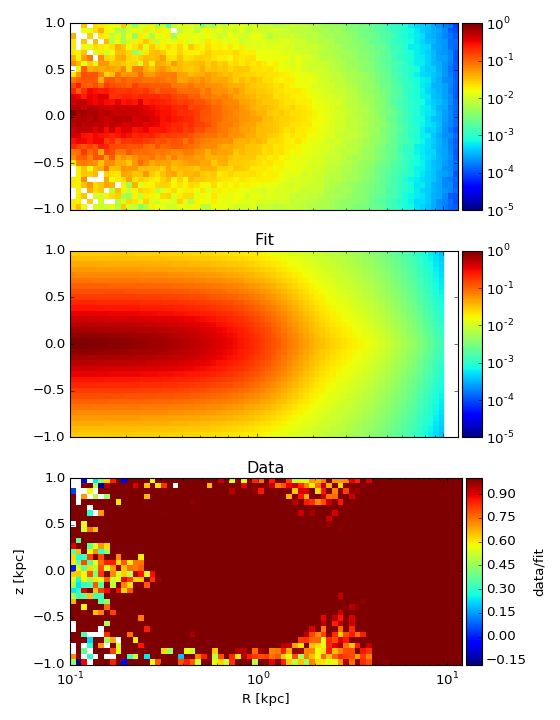

In [30]:
bins = stars_bins -1

x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

U= np.meshgrid(x, y)

fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9],sharex=True, sharey=True)


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist / dens_hist.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

ax1.set_title("Fit")
ax1.set_xscale('log')


Z = stars(U[0],U[1],9, .7 , 1.6 ,1.2,.5,
                    7, 0.4, 0.6,
                    7.8, .8 ,2.5)

fit = ax1.imshow(Z/Z.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)


#print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())##print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist.max(),dens_hist.min())
ratio =  ((Z/Z.max())-(dens_hist/dens_hist.max()))/(dens_hist/dens_hist.max())
#ratio =  np.abs(Z-dens_hist)/(dens_hist)

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')
fig.tight_layout()

In [41]:
"""
Z = stars(U[0],U[1],8, .5 , 1.6 ,1.,.5,
                    8, 0.05, 0.7,
                    8, 0.25 ,.9)



Z = stars(U[0],U[1],9, .7 , 1.6 ,1.2,.5,
                    7, 0.4, 0.6,
                    7.8, 1. ,2.5)
"""

'\nZ = stars(U[0],U[1],8, .5 , 1.6 ,1.,.5,\n                    8, 0.05, 0.7,\n                    8, 0.25 ,.9)\n\n\n\nZ = stars(U[0],U[1],9, .7 , 1.6 ,1.2,.5,\n                    7, 0.4, 0.6,\n                    7.8, 1. ,2.5)\n'

In [62]:
m1=Minuit(chi2_st, 
         B_0=9,  error_B_0=0.5,     limit_B_0=(7,10.7),
         r0=0.5,     error_r0=0.1,     limit_r0=(0.01,1.6),
         al=1.6,     fix_al=True, # error_al=0.1,    limit_al=(0,5.),
         r_cut=1.,  error_r_cut=0.1,   limit_r_cut=(1,3.),
         q=0.5,      fix_q=True,  # error_q=0.1,     limit_q=(0,1.),
         d_0=7,    error_d_0=0.5,     limit_d_0=(7,10.5),
         z_d=.4,  error_z_d=0.2,  limit_z_d=(0.,1.),
         Rd=0.6,     error_Rd=0.01,        limit_Rd=(2.,7.0),
         D_0=7.8,    error_D_0=0.5,     limit_D_0=(7.,10.5),
         z_D=.8,  error_z_D=0.02,  limit_z_D=(0.7,2.9),
         RD=4.,     error_RD=0.01,        limit_RD=(3,4.5),
         print_level=0)
m1.migrad();

err = 4
upp = 1.5
low = 0.5
m2=Minuit(mass_check, 
         B_0=m1.values['B_0'], error_B_0=m1.values['B_0']*err, limit_B_0=(m1.values['B_0']*low,m1.values['B_0']*upp),
         r0=m1.values['r0'], error_r0=m1.values['r0']*err, limit_r0=(m1.values['r0']*low,m1.values['r0']*upp),
         al=m1.values['al'], error_al=m1.values['al']*err, limit_al=(m1.values['al']*low,m1.values['al']*upp),
         r_cut=m1.values['r_cut'],  error_r_cut=m1.values['r_cut']*err, limit_r_cut=(m1.values['r_cut']*low,m1.values['r_cut']*upp),
         q=m1.values['q'], error_q=m1.values['q']*err, limit_q=(m1.values['q']*low,m1.values['q']*upp),
         d_0=m1.values['d_0'], error_d_0=m1.values['d_0']*err, limit_d_0=(m1.values['d_0']*low,m1.values['d_0']*upp),
         z_d=m1.values['z_d'], error_z_d=m1.values['z_d']*err,  limit_z_d=(m1.values['z_d']*low,m1.values['z_d']*upp),
         Rd=m1.values['Rd'], error_Rd=m1.values['Rd']*err, limit_Rd=(m1.values['Rd']*low,m1.values['Rd']*upp),
         D_0=m1.values['D_0'], error_D_0=m1.values['D_0']*err, limit_D_0=(m1.values['D_0']*low,m1.values['D_0']*upp),
         z_D=m1.values['z_D'], error_z_D=m1.values['z_D']*err,  limit_z_D=(m1.values['z_D']*low,m1.values['z_D']*upp),
         RD=m1.values['RD'], error_RD=m1.values['RD']*err, limit_RD=(m1.values['RD']*low,m1.values['RD']*upp))
#         print_level=0)

m2.migrad();


FCN = 5.96046447754e-08 
 TOTAL NCALL = 469 
 NCALLS = 469 
 
 
 EDM = 2.86282698927 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 11.2173 
 6.65717 
 0 
 0 
 4.5 
 13.5 
 
 
 
 
 2 
 r0 
 0.499909 
 0.355163 
 0 
 0 
 0.25 
 0.75 
 
 
 
 
 3 
 al 
 1.60018 
 1.13663 
 0 
 0 
 0.8 
 2.4 
 
 
 
 
 4 
 r_cut 
 0.999916 
 0.710349 
 0 
 0 
 0.500000953674 
 1.50000286102 
 
 
 
 
 5 
 q 
 0.499911 
 0.355163 
 0 
 0 
 0.25 
 0.75 
 
 
 
 
 6 
 d_0 
 8.29774 
 5.1659 
 0 
 0 
 3.50000166893 
 10.5000050068 
 
 
 
 
 7 
 z_d 
 0.398467 
 0.283792 
 0 
 0 
 0.2 
 0.6 
 
 
 
 
 8 
 Rd 
 1.9964 
 1.41991 
 0 
 0 
 1.00000238419 
 3.00000715256 
 
 
 
 
 9 
 D_0 
 7.7993 
 5.54071 
 0 
 0 
 3.9 
 11.7 
 
 
 
 
 10 
 z_D 
 0.798282 
 0.567898 
 0 
 0 
 0.4 
 1.2 
 
 
 
 
 11 
 RD 
 3.99643 
 2.84065 
 0 
 0 
 2.0 
 6.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 1.122e+01 & 6.657e+00 & & & 4.500e+00 & 1.350e+01 & \\
\hline
2 & r0 & 4.999e-01 & 3.552e-01 & & & 2.500e-01 & 7.500e-01 & \\
\hline
3 & al & 1.600e+00 & 1.137e+00 & & & 8.000e-01 & 2.400e+00 & \\
\hline
4 & $r_{cut}$ & 9.999e-01 & 7.103e-01 & & & 5.000e-01 & 1.500e+00 & \\
\hline
5 & q & 4.999e-01 & 3.552e-01 & & & 2.500e-01 & 7.500e-01 & \\
\hline
6 & $d_{0}$ & 8.298e+00 & 5.166e+00 & & & 3.500e+00 & 1.050e+01 & \\
\hline
7 & $z_{d}$ & 3.985e-01 & 2.838e-01 & & & 2.000e-01 & 6.000e-01 & \\
\hline
8 & Rd & 1.996e+00 & 1.420e+00 & & & 1.000e+00 & 3.000e+00 & \\
\hline
9 & $D_{0}$ & 7.799e+00 & 5.541e+00 & & & 3.900e+00 & 1.170e+01 & \\
\hline
10 & $z_{D}$ & 7.983e-01 & 5.679e-01 & & & 4.000e-01 & 1.200e+00 & \\
\hline
11 & RD & 3.996e+00 & 2.841e+00 & & & 2.000e+00 & 6.000e+00 & \\
\hline
\end{tabular}

In [63]:

def mass_integrated(edge,B0,d0,D0):
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    #"""

    def integrand(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
        return 2. * np.pi * R * stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(B0, m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                      m2.values['q'], d0, m2.values['z_d'], m2.values['Rd'],D0, m2.values['z_D'], m2.values['RD']))
    
    F = i[0] #firs level fit
    return F 

get_masses = np.vectorize(mass_integrated)

def thinD_integrated(edge,d0):
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    #"""

    def integrand(R,z,d_0,z_d,Rd):
        return 2. * np.pi * R * McMDisc(R,z,d_0,z_d,Rd)

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(d0, m2.values['z_d'], m2.values['Rd']))
    
    F = i[0] #firs level fit
    return F 

get_masses_thin = np.vectorize(thinD_integrated)


def thickD_integrated(edge,D0):
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    #"""

    def integrand(R,z,D_0,z_D,RD):
        return 2. * np.pi * R * McMDisc(R,z,D_0,z_D,RD)

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(D0, m2.values['z_D'], m2.values['RD']))
    
    F = i[0] #firs level fit
    print F
    return F 

get_masses_thick = np.vectorize(thickD_integrated)


def bulge_integrated(edge,B0):
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    #"""

    def integrand(R,z,B_0,r0,al,r_cut,q):
        return 2. * np.pi * R * McMBulge(R,z,B_0,r0,al,r_cut,q)

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(B0, m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                      m2.values['q']))
    
    F = i[0] #firs level fit
    return F 

get_masses_b = np.vectorize(bulge_integrated)

get_mass_data = np.vectorize(lambda u :np.sum(myhydro.st.mass[np.where((myhydro.st.R<u)&(np.abs(myhydro.st.pos3d[:,2])<u/10.))]))


In [64]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhydro.r200),20)
level1 = get_masses(r_masses,9.3,8.1,8.)
data_mass = get_mass_data(r_masses)

In [65]:
def chimass(B0,d0,D0):
    c = np.log10(get_masses(r_masses,B0,d0,D0))-np.log10(data_mass)
    return np.sum(c**2)


mmass=Minuit(chimass, 
         B0=9.5,  error_B0=0.5,     limit_B0=(7,10.7),
         d0=8.5,  error_d0=0.5,     limit_d0=(7,10.7),
         D0=8.5,  error_D0=0.5,     limit_D0=(7,10.7))
#         print_level=0)
mmass.migrad();

FCN = 0.00708876837463 
 TOTAL NCALL = 124 
 NCALLS = 124 
 
 
 EDM = 4.46078571576e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B0 
 10.3674 
 3.53365 
 0 
 0 
 7.0 
 10.7 
 
 
 
 
 2 
 d0 
 8.9622 
 1.98934 
 0 
 0 
 7.0 
 10.7 
 
 
 
 
 3 
 D0 
 8.70016 
 1.19145 
 0 
 0 
 7.0 
 10.7 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & B0 & 1.037e+01 & 3.534e+00 & & & 7.000e+00 & 1.070e+01 & \\
\hline
2 & d0 & 8.962e+00 & 1.989e+00 & & & 7.000e+00 & 1.070e+01 & \\
\hline
3 & D0 & 8.700e+00 & 1.191e+00 & & & 7.000e+00 & 1.070e+01 & \\
\hline
\end{tabular}

In [66]:
level1 = get_masses(r_masses,mmass.values["B0"],mmass.values["d0"],mmass.values["D0"])


<IPython.core.display.Javascript object>


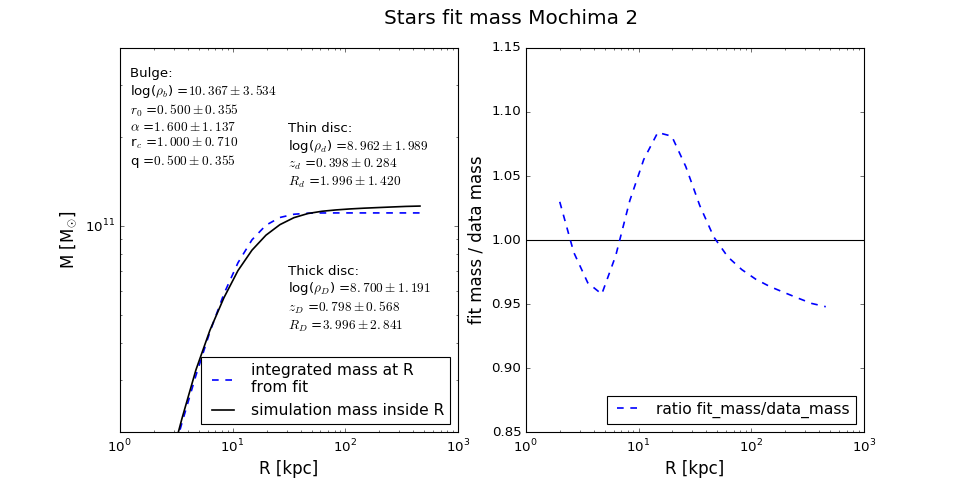

In [67]:
bulge = "Bulge: \n"
bulge += r"log($\rho _b$) =$ {0:.3f} \pm {1:.3f}$".format(mmass.values["B0"],mmass.errors["B0"])+"\n"
bulge += r"$r_0$ =$ {0:.3f} \pm {1:.3f}$".format(m2.values["r0"],m2.errors["r0"])+"\n"
bulge += r"$\alpha$ =$ {0:.3f} \pm {1:.3f}$".format(m2.values["al"],m2.errors["al"])+"\n"
bulge += r"r$_c$ =$ {0:.3f} \pm {1:.3f}$".format(m2.values["r_cut"],m2.errors["r_cut"])+"\n"
bulge += r"q =$ {0:.3f} \pm {1:.3f}$".format(m2.values["q"],m2.errors["q"])+"\n"

thin_disc = "Thin disc: \n"
thin_disc += r"log($\rho _d$) =$ {0:.3f} \pm {1:.3f}$".format(mmass.values["d0"],mmass.errors["d0"])+"\n"
thin_disc += r"$z_d$ =$ {0:.3f} \pm {1:.3f}$".format(m2.values["z_d"],m2.errors["z_d"])+"\n"
thin_disc += r"$R_d$ =$ {0:.3f} \pm {1:.3f}$".format(m2.values["Rd"],m2.errors["Rd"])+"\n"

thik_disc = "Thick disc: \n"
thik_disc += r"log($\rho _D$) =$ {0:.3f} \pm {1:.3f}$".format(mmass.values["D0"],mmass.errors["D0"])+"\n"
thik_disc += r"$z_D$ =$ {0:.3f} \pm {1:.3f}$".format(m2.values["z_D"],m2.errors["z_D"])+"\n"
thik_disc += r"$R_D$ =$ {0:.3f} \pm {1:.3f}$".format(m2.values["RD"],m2.errors["RD"])+"\n"



fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Stars fit mass Mochima 2",fontsize=18)
fig.text(0.135,0.62,bulge,fontsize=12)
fig.text(0.3,0.58,thin_disc,fontsize=12)
fig.text(0.3,0.28,thik_disc,fontsize=12)

ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim([2e10,4e11])
ax[1].set_ylim([0.85,1.15])
ax[0].plot(r_masses,level1,'b--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[1].axhline(y=1,c='k')


ax[0].plot(r_masses,data_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses,level1/data_mass,'b--',lw=1.5,label="ratio fit_mass/data_mass")
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

In [68]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "#################### Stars ########################"

print bulge
print thin_disc
print thik_disc

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
#################### Stars ########################
Bulge: 
log($\rho _b$) =$ 10.367 \pm 3.534$
$r_0$ =$ 0.500 \pm 0.355$
$\alpha$ =$ 1.600 \pm 1.137$
r$_c$ =$ 1.000 \pm 0.710$
q =$ 0.500 \pm 0.355$

Thin disc: 
log($\rho _d$) =$ 8.962 \pm 1.989$
$z_d$ =$ 0.398 \pm 0.284$
$R_d$ =$ 1.996 \pm 1.420$

Thick disc: 
log($\rho _D$) =$ 8.700 \pm 1.191$
$z_D$ =$ 0.798 \pm 0.568$
$R_D$ =$ 3.996 \pm 2.841$



In [106]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "#################### Stars ########################"

print bulge
print thin_disc
print thik_disc

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
#################### Stars ########################
Bulge: 
log($\rho _b$) =$ 10.325 \pm 3.495$
$r_0$ =$ 0.502 \pm 0.000$
$\alpha$ =$ 1.595 \pm 0.000$
r$_c$ =$ 1.002 \pm 0.000$
q =$ 0.502 \pm 0.000$

Thin disc: 
log($\rho _d$) =$ 9.166 \pm 2.930$
$z_d$ =$ 0.403 \pm 0.000$
$R_d$ =$ 2.006 \pm 0.000$

Thick disc: 
log($\rho _D$) =$ 8.435 \pm 1.091$
$z_D$ =$ 0.814 \pm 0.000$
$R_D$ =$ 5.051 \pm 0.000$



<IPython.core.display.Javascript object>


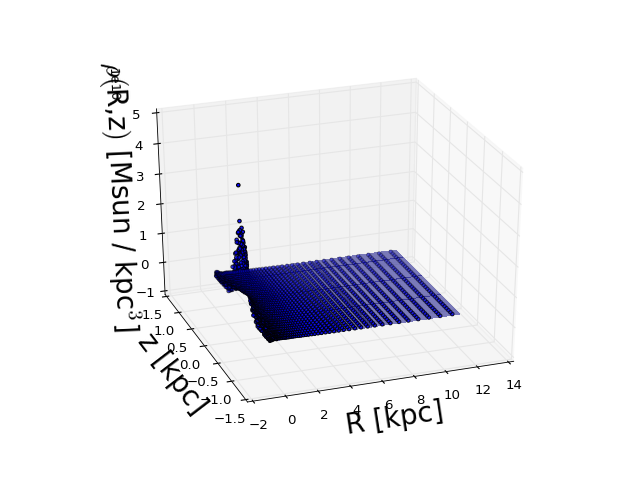

2346
2346
2346


In [107]:

bins = stars_bins
x = xedges#np.logspace(-1,np.log10(25),bins)
y = yedges#np.linspace(-6,6,bins/2.5)
U= np.meshgrid(x, y)


#Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
#          m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])
Z = stars(U[0],U[1],mmass.values['B0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
          m2.values['q'], mmass.values['d0'], m2.values['z_d'], m2.values['Rd'],
          mmass.values['D0'],m2.values['z_D'], m2.values['RD'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_zscale('log')
#ax.set_xlim([0,3])

R_test = (x[1:] + x[:-1])/2
Z_test = (y[1:] + y[:-1])/2
X,Y = np.meshgrid(R_test, Z_test)
x_s = X.reshape(1,len(X)*len(X[0]))[0]
y_s = Y.reshape(1,len(Y)*len(Y[0]))[0]
dens = dens_hist.reshape(1,len(dens_hist)*len(dens_hist[0]))[0]
print len(x_s)
print len(y_s)
print len(dens)
ax.set_xlabel("R [kpc]",fontsize=25)
my_col = cm.jet(Z/Z.max())
ax.set_ylabel("z [kpc]",fontsize=25)
ax.set_zlabel(r"$\rho($R,z$)$ [Msun / kpc$^3$]",fontsize=25)

ax.scatter(x_s, y_s,dens,marker='.',s=40)
surf = ax.plot_surface(U[0], U[1], Z, cmap=cm.coolwarm, facecolors = my_col,alpha=0.5,
                       linewidth=0, antialiased=False)

<IPython.core.display.Javascript object>


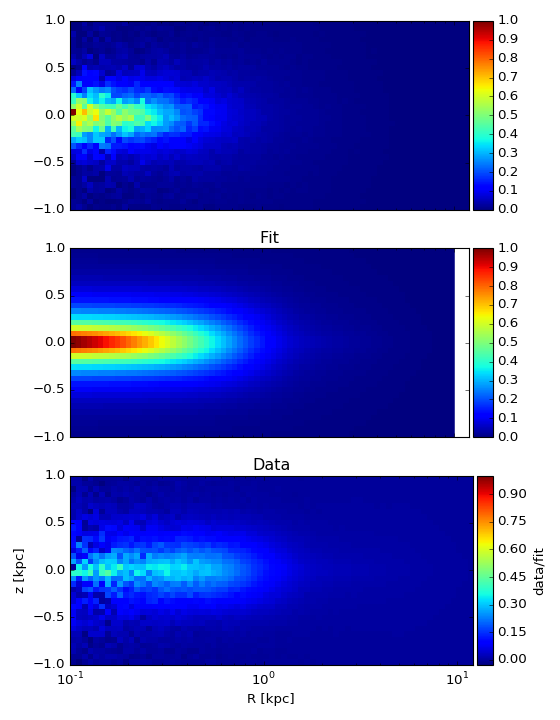

In [108]:
bins = stars_bins -1

x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x, y)



Z = stars(U[0],U[1],mmass.values['B0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],m2.values['q'],
          mmass.values['d0'], m2.values['z_d'], m2.values['Rd'],
          mmass.values['D0'], m2.values['z_D'], m2.values['RD'])




fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9],sharex=True, sharey=True)


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist / dens_hist.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')



fit = ax1.imshow(Z/Z.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]])#,norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)


#print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())##print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist.max(),dens_hist.min())
ratio =  ((Z/Z.max())-(dens_hist/dens_hist.max()))#/(dens_hist/dens_hist.max())
#ratio =  np.abs(Z-dens_hist)/(dens_hist)

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')
fig.tight_layout()

# gas

In [19]:
log_hsml = np.log10(myhydro.gs.hsml.min())

In [20]:
gs_bins=40
edge = 20
zedge = edge/30.
x_gs = np.logspace(-0.5,np.log10(edge),gs_bins)
y_gs = np.linspace(-zedge,zedge,gs_bins)
dens_hist_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
sigma_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
for i in range(len(x_gs[:-1])):
    for j in range(len(y_gs[:-1])):
        Rcon = (myhydro.gs.R >= x_gs[i] )&(myhydro.gs.R < x_gs[i+1] )
        Zcon = (myhydro.gs.pos3d[:,2] >= y_gs[j])&(myhydro.gs.pos3d[:,2] < y_gs[j+1])
        mass = np.sum(myhydro.gs.mass[np.where(Rcon&Zcon)])
        sigma_gs[j][i] = np.std(myhydro.gs.rho[np.where(Rcon&Zcon)])
        volume = np.pi * (y_gs[j+1]-y_gs[j]) * (x_gs[i+1]**2 - x_gs[i]**2)
        dens_hist_gs [j][i] = mass / volume 
    
    


In [21]:
dens_hist_gs = np.nan_to_num(dens_hist_gs)

<IPython.core.display.Javascript object>


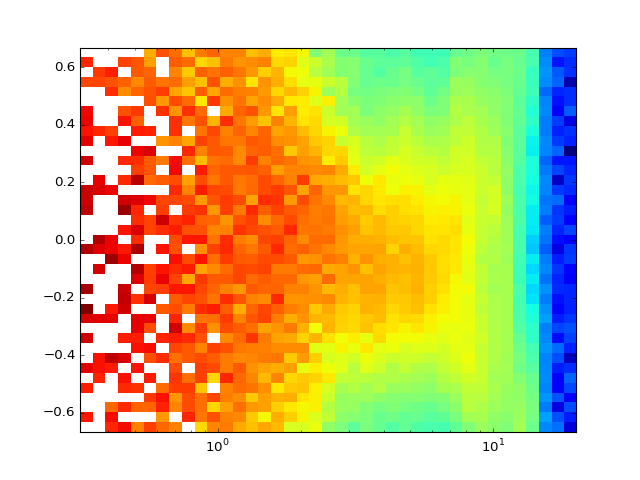

In [22]:
fig, ax = plt.subplots()
ax.set_xscale('log')
real =  plt.imshow(dens_hist_gs, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
           extent=[x_gs[0], x_gs[-1], y_gs[0], y_gs[-1]])

#cbar = plt.colorbar(real)#,orientation='horizontal')

In [26]:
#def gas(R,z,D_0,z_d,Rm,Rd):        
#    return (10**D_0) * np.exp(- (Rm / R) - (R / Rd)) / (np.cosh(z /2./ z_d))**2


def gas(R,z,D_0,z_d,Rd):
        
    return (10**D_0) * np.exp( - (R / Rd)) / (np.cosh(z /2./ z_d))**2

R_array = (x_gs[1:] + x_gs[:-1])/2
Z_array = (y_gs[1:] + y_gs[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)


def chi2_gas(D_0,z_d,Rd):
    chi2_array =np.array([])
    expected = gas(R,Z,D_0,z_d,Rd)
    observed = dens_hist_gs
    c = ((observed) - (expected))**2 / sigma_gs**2
    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)


def mass_check_gas(D_0,z_d,Rd):
    xe, ye = np.linspace(0,edge,gs_bins ),np.linspace(-edge/15.,edge/15.,gs_bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * gas(U[0],U[1],D_0,z_d,Rd)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhydro.gs.mass[np.where((myhydro.gs.R<edge)&(np.abs(myhydro.gs.pos3d[:,2])<edge/10.))])
    N = len(myhydro.gs.mass[np.where((myhydro.gs.R<edge)&(np.abs(myhydro.gs.pos3d[:,2])<edge/10.))])
    diff = np.abs(np.log10(data_in) - np.log10(F))
    return  diff

In [27]:
mg1=Minuit(chi2_gas, 
           D_0=8.4,    error_D_0=0.7,     limit_D_0=(8.5,9.5),
           z_d=0.2,  error_z_d=0.1,  limit_z_d=(0.001,2),
           Rd=2.,     error_Rd=0.1,        limit_Rd=(0.3,4),
           print_level=0)
mg1.migrad();

err = 0.01
upp = 1.5
low = 0.5
mg2=Minuit(mass_check_gas, 
         D_0=mg1.values['D_0'], error_D_0=mg1.values['D_0']*err, limit_D_0=(mg1.values['D_0']*low,mg1.values['D_0']*upp),
         z_d=mg1.values['z_d'], error_z_d=mg1.values['z_d']*err,  limit_z_d=(mg1.values['z_d']*low,mg1.values['z_d']*upp),
         Rd=mg1.values['Rd'], error_Rd=mg1.values['Rd']*err, limit_Rd=(mg1.values['Rd']*low,mg1.values['Rd']*upp))

mg2.migrad();

FCN = 1.53948485426e-06 
 TOTAL NCALL = 189 
 NCALLS = 189 
 
 
 EDM = 3.19248154388e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 D_0 
 9.20749 
 4.45533e-06 
 0 
 0 
 4.25000047684 
 12.7500014305 
 
 
 
 
 2 
 z_d 
 0.199183 
 0.0108016 
 0 
 0 
 0.1 
 0.3 
 
 
 
 
 3 
 Rd 
 1.98971 
 0.0779861 
 0 
 0 
 1.0 
 3.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $D_{0}$ & 9.207e+00 & 4.455e-06 & & & 4.250e+00 & 1.275e+01 & \\
\hline
2 & $z_{d}$ & 1.992e-01 & 1.080e-02 & & & 1.000e-01 & 3.000e-01 & \\
\hline
3 & Rd & 1.990e+00 & 7.799e-02 & & & 1.000e+00 & 3.000e+00 & \\
\hline
\end{tabular}

In [28]:

def mass_integrated_gas(edge):
    """
    integraties the amount of mass obtained by the gas fit
     gas(R,z,D_0,z_d,Rd)
    """
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * U[0] * gas(U[0],U[1],mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd'])

    def integrand(R,z,D_0,z_d,Rd):
        return 2. * np.pi * R * gas(R,z,D_0,z_d,Rd)

    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg1.values['D_0'], mg1.values['z_d'], mg1.values['Rd']))

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd']))
    
    F = j[0] #firs level fit
    F2 = i[0] # second level fit
    return F , F2
#print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
#print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
#print "data = ",np.sum(myhydro.st.mass[np.where((myhydro.st.R<edge)&(np.abs(myhydro.st.pos3d[:,2])<zedge))])
get_masses_gs = np.vectorize(mass_integrated_gas)
get_mass_data_gs = np.vectorize(lambda u :np.sum(myhydro.gs.mass[np.where((myhydro.gs.R<u)&(np.abs(myhydro.gs.pos3d[:,2])<u/10.))]))


In [29]:
def mass_gas(edge,d0,zd,rd):
    """
    integraties the amount of mass obtained by the gas fit
     gas(R,z,D_0,z_d,Rd)
    """
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)

    def integrand(R,z,D_0,z_d,Rd):
        return 2. * np.pi * R * gas(R,z,D_0,z_d,Rd)

    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(d0,zd,rd))
    
    F = j[0] #firs level fit
    return F 

get_mass_GAs = np.vectorize(mass_gas)


In [30]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhydro.r200),20)
glevel1, glevel2 = get_masses_gs(r_masses)
gdata_mass = get_mass_data_gs(r_masses)

In [31]:
def chimass_gs(d0,zs,r0):
    c = np.log10(get_mass_GAs(r_masses,d0,zs,r0))-np.log10(gdata_mass)
    return np.sum(c**2)


mmass_gs=Minuit(chimass_gs, 
         d0=9,  error_d0=0.2,     limit_d0=(6,10.7),
         zs=.1,  error_zs=0.01,     limit_zs=(0.01,1.5),
         r0=3.5,  error_r0=0.1,     limit_r0=(1,8))
#         print_level=0)
mmass_gs.migrad();

FCN = 0.144438863918 
 TOTAL NCALL = 153 
 NCALLS = 153 
 
 
 EDM = 0.000106712563595 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 d0 
 9.22976 
 3.96139 
 0 
 0 
 6.0 
 10.7 
 
 
 
 
 2 
 zs 
 0.0390641 
 1.08786 
 0 
 0 
 0.01 
 1.5 
 
 
 
 
 3 
 r0 
 5.07008 
 5.287 
 0 
 0 
 1.0 
 8.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & d0 & 9.230e+00 & 3.961e+00 & & & 6.000e+00 & 1.070e+01 & \\
\hline
2 & zs & 3.906e-02 & 1.088e+00 & & & 1.000e-02 & 1.500e+00 & \\
\hline
3 & r0 & 5.070e+00 & 5.287e+00 & & & 1.000e+00 & 8.000e+00 & \\
\hline
\end{tabular}

In [32]:
gas_fit_from_mass = get_mass_GAs(r_masses,mmass_gs.values['d0'],mmass_gs.values['zs'],mmass_gs.values['r0'])

In [33]:
texto = "Gas disc results: \n"
texto += r"log($\rho _d$) =$ {0:.3f} \pm {1:.3f}$".format(mmass_gs.values["d0"],mmass_gs.errors["d0"])+"\n"
texto += r"$z_d$ =$ {0:.3f} \pm {1:.3f}$".format(mmass_gs.values["zs"],mmass_gs.errors["zs"])+"\n"
texto += r"$R_d$ =$ {0:.3f} \pm {1:.3f}$".format(mmass_gs.values["r0"],mmass_gs.errors["r0"])+"\n"

fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Gas fit mass Mochima 2",fontsize=18)
fig.text(0.3,0.35,texto,fontsize=12)
ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_ylim([0.85,1.15])
#ax[0].plot(r_masses,glevel1,'b--')
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses, gas_fit_from_mass ,'r--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[0].plot(r_masses,gdata_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses, gas_fit_from_mass/gdata_mass,'r--',lw=1.5,label="ratio fit_mass/data_mass")
#ax[1].plot(r_masses,glevel1/data_mass,'b--')
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

<IPython.core.display.Javascript object>

In [34]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "####################  GAS #########################"

print texto

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
####################  GAS #########################
Gas disc results: 
log($\rho _d$) =$ 9.230 \pm 3.961$
$z_d$ =$ 0.039 \pm 1.088$
$R_d$ =$ 5.070 \pm 5.287$



In [298]:
bins = gs_bins -1


edge = 20
zedge = edge/40.
x_gs = np.logspace(-0.5,np.log10(edge),bins)
y_gs = np.linspace(-zedge,zedge,bins)


x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x_gs, y_gs)


"""
Z = gas(U[0],U[1],9.3, 0.2 , 1.2)
"""
#"""
Z = gas(U[0],U[1],mg2.values['D_0'], 0.5 , mg2.values['Rd'])
#"""



fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9])


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist_gs, interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')


Z = gas(U[0],U[1],8.5, 0.1 , 2.)

fit = ax1.imshow(Z, interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]],norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

#ax.set_title("Data")

#real = ax.imshow(dens_hist, interpolation='nearest', origin='low',aspect='auto',
#                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())
print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist_gs.max(),dens_hist.min())
ratio =  np.abs(Z-dens_hist_gs)/dens_hist_gs

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')

<IPython.core.display.Javascript object>

fit  : max = 2.700e+08, min = 3.818e+02
data : max = 2.963e+09, min = 0.000e+00


# COMPARISON

<IPython.core.display.Javascript object>


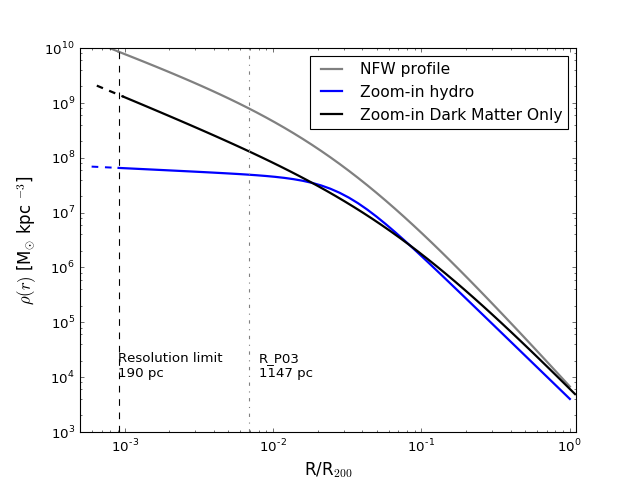

In [366]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0.0005,1.1])
ax.set_ylim([1e3,1e10])
ax.set_xlabel(r'R/R$_{200}$',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
r_in = np.logspace(-1,np.log10(myhydro.gs.hsml.min()))
r_out = np.logspace(np.log10(myhydro.gs.hsml.min()),np.log10(myhydro.r200))
##NFW
ax.plot(r_in/myhydro.r200,(abg_profile(r_in,8.45,m_rho_hydro.values['r_s'],1,3,1)),
        color="gray",ls="-",lw=1.8)
ax.plot(r_out/myhydro.r200,(abg_profile(r_out,8.45,m_rho_hydro.values['r_s'],1,3,1)),
        color="gray",ls="-",lw=2,label="NFW profile")

## Hydro

ax.plot(r_in/myhydro.r200,(abg_profile(r_in,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])),
        "b--",lw=1.8)
ax.plot(r_out/myhydro.r200,(abg_profile(r_out,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])),
        "b-",lw=2,label = "Zoom-in hydro")
#DMO
ax.plot(r_in/myDMO.r200,(abg_profile(r_in,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k--",lw=2)
ax.plot(r_out/myDMO.r200,(abg_profile(r_out,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k-",lw=2,label = "Zoom-in Dark Matter Only")
ax.axvline(myhydro.gs.hsml.min()/myhydro.r200,color="k",linestyle="--")
ax.text(9e-4,1e4,"Resolution limit\n190 pc")
ax.axvline(R_P03/myhydro.r200,color="gray",linestyle="-.")
ax.text(8e-3,1e4,"R_P03\n{0} pc".format(int(R_P03*1e3)))

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

In [368]:
def maxw(v,sigma):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * np.exp(- v**2 / 2. / sigma**2)
get_maxw = np.vectorize(maxw)

v= np.linspace(0,600,100)
maxw = get_maxw(v,220/np.sqrt(2))
N = simps(maxw,v)
maxw = maxw/N

maxw2 = get_maxw(v,278/np.sqrt(2))
N = simps(maxw2,v)
maxw2 = maxw2/N

maxw3 = get_maxw(v,180/np.sqrt(2))
N = simps(maxw3,v)
maxw3 = maxw3/N

dmo_sun = (myDMO.dm.r>7.5)&(myDMO.dm.r<8.5)
hyd_sun = (myhydro.dm.r>7.5)&(myhydro.dm.r<8.5) 
fdv_dmo,bin_dmo = np.histogram(myDMO.dm.v[dmo_sun],bins=90,normed=True) 
fdv_hyd,bin_hyd = np.histogram(myhydro.dm.v[hyd_sun],bins=90,normed=True) 

<IPython.core.display.Javascript object>


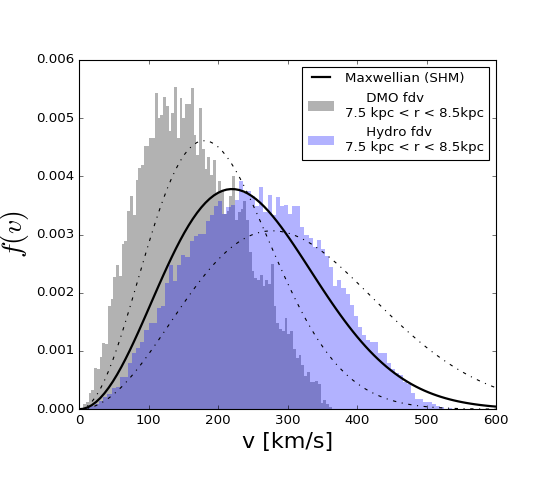

In [369]:

fig, ax = plt.subplots(figsize=[7,6])
plt.tight_layout(pad=4)
v= np.linspace(0,600,100)
ax.set_xlabel("v [km/s]",fontsize=20)
ax.set_ylabel(r"$f(v)$",fontsize=25)

ax.plot(v,maxw,"k",lw=2,label="Maxwellian (SHM)")
ax.plot(v,maxw2,"k-.",alpha=1)
ax.plot(v,maxw3,"k-.",alpha=1)

ax.bar((bin_dmo[:-1]+bin_dmo[1:])/2,fdv_dmo,width=bin_dmo[1]-bin_dmo[0],
       linewidth=0,color="k", alpha=0.3,label="     DMO fdv\n7.5 kpc < r < 8.5kpc")
ax.bar((bin_hyd[:-1]+bin_hyd[1:])/2,fdv_hyd,width=bin_hyd[1]-bin_hyd[0],
       linewidth=0,color="b", alpha=0.3,label="     Hydro fdv\n7.5 kpc < r < 8.5kpc")
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)
frame = legend.get_frame()